**классификатор изображений на основе свёрточной сети**

Евгений Борисов borisov.e@solarl.ru

In [1]:
from os.path import join as pjoin
# from os import listdir
import numpy as np
#import numpy.random as rng
from matplotlib import pyplot as plt

## загружаем датасет

In [2]:
DATASET_FOLDER = '../data/fashion-mnist'

In [3]:
import gzip
import idx2numpy

In [6]:
# !mkdir -p ../data/fashion-mnist
# !wget -P ../data/fashion-mnist -c http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
# !wget -P ../data/fashion-mnist -c http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
# !wget -P ../data/fashion-mnist -c http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
# !wget -P ../data/fashion-mnist -c http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2021-05-05 12:47:23--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Распознаётся fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)… 52.219.72.15
Подключение к fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.72.15|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 26421880 (25M) [binary/octet-stream]
Сохранение в: «../data/fashion-mnist/train-images-idx3-ubyte.gz»

train-images-idx3-u 100%[===================>]  25,20M  4,30MB/s    за 16s     

2021-05-05 12:47:40 (1,54 MB/s) - «../data/fashion-mnist/train-images-idx3-ubyte.gz» сохранён [26421880/26421880]

--2021-05-05 12:47:40--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Распознаётся fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)… 52.219.7

In [7]:
with gzip.open( pjoin(DATASET_FOLDER,'train-images-idx3-ubyte.gz'),'rb') as f:
    x_train = np.expand_dims( idx2numpy.convert_from_string(f.read()), axis=-1 )
    
with gzip.open( pjoin(DATASET_FOLDER,'train-labels-idx1-ubyte.gz'),'rb') as f:
    y_train = idx2numpy.convert_from_string(f.read())

with gzip.open( pjoin(DATASET_FOLDER,'t10k-images-idx3-ubyte.gz'),'rb') as f:
    x_test = np.expand_dims( idx2numpy.convert_from_string(f.read()), axis=-1 )
    
with gzip.open( pjoin(DATASET_FOLDER,'t10k-labels-idx1-ubyte.gz'),'rb') as f:
    y_test = idx2numpy.convert_from_string(f.read())

In [8]:
# from tensorflow.keras.datasets import mnist
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# from tensorflow.keras.datasets import fashion_mnist
# (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [9]:
def ar2im(x): return ((x-x.min())/(x.max()-x.min())*255.).astype(np.uint8)

def plot_samples(X,n_show=15,columns=15,cmap='gray_r'):
    ii = np.random.permutation(X.shape[0])[:n_show]
    plt.figure(figsize=(2*columns,2*(n_show //columns+1)))
    for n,xi in enumerate(X[ii]):
        img = ar2im(xi)
        plt.subplot( n_show//columns+1, columns, n+1)
        plt.axis(False)
        plt.imshow(img,cmap=cmap)

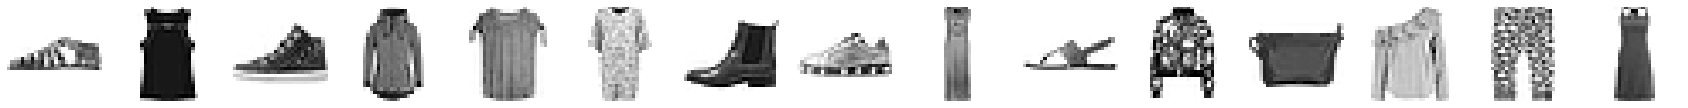

In [10]:
plot_samples(x_train)

## подготовка данных

In [11]:
def im2ar(im): return (im-127.5)/127.5
x_train, x_test = im2ar(x_train), im2ar(x_test)

x_train.shape, y_test.shape

((60000, 28, 28, 1), (10000,))

In [12]:
def one_hot_enc(y,nc=0):
    n = y.shape[0] # количество примеров
    nc = nc if nc>0 else y.max()+1 # количество классов
    assert nc>y.max()
    return np.eye(n,nc)[y]

nc = y_train.max()+1 # количество классов
y_train, y_test = one_hot_enc(y_train,nc=nc),one_hot_enc(y_test,nc=nc)

y_train.shape, y_test.shape

((60000, 10), (10000, 10))

## Модель

In [13]:
from tabulate import tabulate
import tensorflow as tf
from tensorflow.test import is_built_with_cuda
from tensorflow.python.client.device_lib import list_local_devices

def tf_info(tablefmt='html'):
    res = [ ['tensorflow','%s'%(tf.__version__)],['keras','%s'%(tf.keras.__version__)] ]
    if is_built_with_cuda():
        res.extend( [ 
              [ s.strip().split(': ') for s in d.physical_device_desc.split(',')  ]
               for d in list_local_devices() 
              if d.device_type == 'GPU' # and d.name==tf.test.gpu_device_name()
            ][0] )
    else:
        res.append(['','no CUDA support'])
    return tabulate( res, tablefmt=tablefmt )

tf_info()


tensorflow,2.4.1
keras,2.4.0
device,0
name,NVIDIA GeForce GTX 1060 6GB
pci bus id,0000:01:00.0
compute capability,6.1


In [14]:
# import tensorflow as tf
# from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model

In [15]:
INPUT_SHAPE = x_train.shape[1:]
N_CLASSES = y_train.shape[1]

In [16]:
model = Sequential()
model.add(Input( shape=INPUT_SHAPE, name='input1' ) )
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', name='conv1', ))
model.add(MaxPooling2D(pool_size=2,strides=2, name='mpool1',))
model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu', name='conv2', ))
model.add(Flatten(name='flatten1'))
model.add(Dense(512,activation='relu',name='hidden1',))
model.add(Dense(N_CLASSES, activation='softmax',name='out_softmax',))

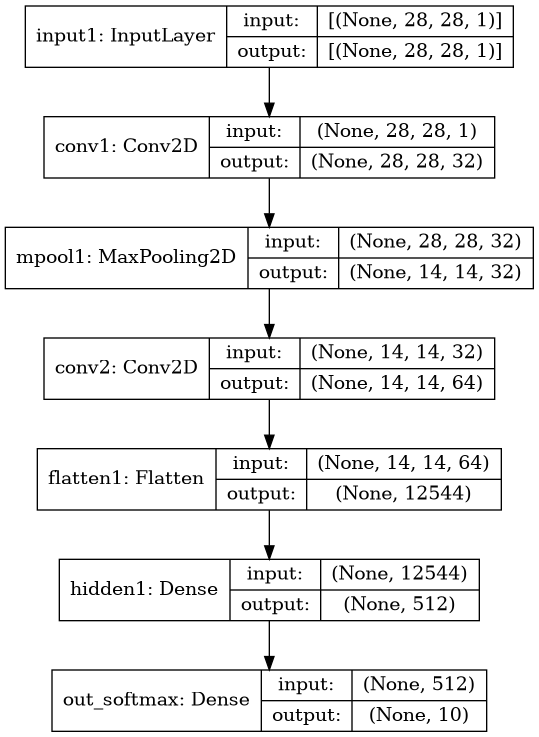

In [17]:
# model.summary()
plot_model(model,to_file='cnn.png', show_layer_names=True, show_shapes=True )

## Обучение

In [18]:
%%time

N_EPOCH = 20
BATCH_SIZE = 128
VERBOSE = 1
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 2e-4

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=["accuracy"])

history = model.fit(x_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=N_EPOCH, 
                    verbose=VERBOSE, 
                    validation_split=VALIDATION_SPLIT)

Epoch 1/20
375/375 [==============================] - 4s 9ms/step - loss: 0.1605 - accuracy: 0.7069 - val_loss: 0.0739 - val_accuracy: 0.8609
Epoch 2/20
375/375 [==============================] - 3s 8ms/step - loss: 0.0687 - accuracy: 0.8722 - val_loss: 0.0645 - val_accuracy: 0.8783
Epoch 3/20
375/375 [==============================] - 3s 8ms/step - loss: 0.0591 - accuracy: 0.8882 - val_loss: 0.0592 - val_accuracy: 0.8888
Epoch 4/20
375/375 [==============================] - 3s 8ms/step - loss: 0.0543 - accuracy: 0.8977 - val_loss: 0.0537 - val_accuracy: 0.8988
Epoch 5/20
375/375 [==============================] - 3s 8ms/step - loss: 0.0495 - accuracy: 0.9066 - val_loss: 0.0524 - val_accuracy: 0.9024
Epoch 6/20
375/375 [==============================] - 3s 8ms/step - loss: 0.0454 - accuracy: 0.9158 - val_loss: 0.0491 - val_accuracy: 0.9062
Epoch 7/20
375/375 [==============================] - 3s 8ms/step - loss: 0.0420 - accuracy: 0.9210 - val_loss: 0.0486 - val_accuracy: 0.9090
Epoch 

## Тестирование

In [19]:
score = model.evaluate(x_test, y_test, verbose=False)
print('Test accuracy:', score[1])

Test accuracy: 0.9200000166893005


In [20]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

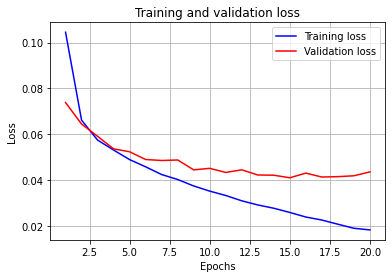

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()

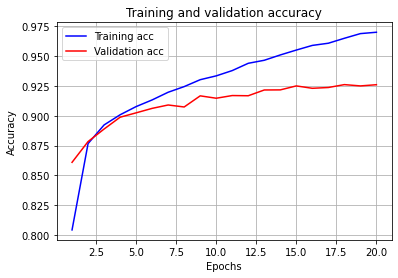

In [22]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()

---

In [23]:
# ii = np.random.permutation(x_test.shape[0])[:10]
# p = model.predict(x_test[ii,:])
# r = np.argmax(p,axis=1)
# np.argmax(y_test,axis=1)

In [24]:
def plot_test_samples(X,y,class_names,n_show=25,columns=10,cmap='gray_r'):
    ii = np.random.permutation(X.shape[0])[:n_show]
    
    p = model.predict(X[ii,:])
    r = np.argmax(p,axis=1)
    yii = y[ii]

    plt.figure(figsize=(2*columns,3*(n_show //columns+1)))
    for n,xi in enumerate(X[ii]):
        img = ar2im(xi)
        plt.subplot( n_show//columns+1, columns, n+1)
            
        t = class_names[r[n]] if yii[n]==r[n] else '%s\n[%s]'%(class_names[r[n]],class_names[yii[n]].upper())
        c = 'g' if yii[n]==r[n] else 'r'
        
        plt.title(t,color=c)
        plt.axis(False)
        plt.imshow(img,cmap=cmap)
        

In [25]:
class_names = [ 'футболка', 
                'брюки', 
                'свитер', 
                'платье', 
                'пальто', 
                'сандали', 
                'рубашка', 
                'тапки', 
                'сумка', 
                'полусапожки', ]

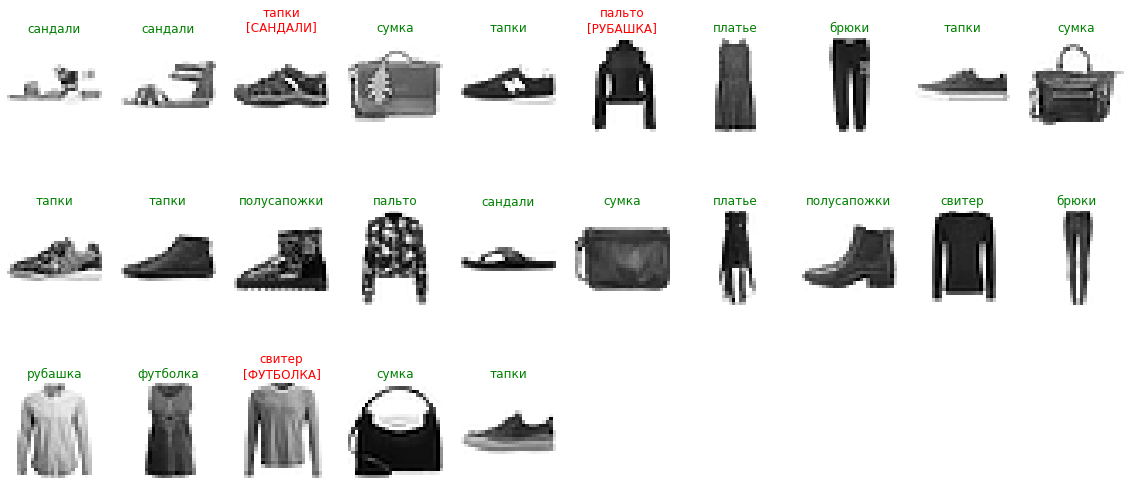

In [26]:
plot_test_samples(x_test,np.argmax(y_test,axis=1),class_names)